In [87]:
from special_neurons import get_most_negative_sets
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import re

model_name = 'EleutherAI/pythia-70m'
model_name = 'EleutherAI/pythia-160m'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_og = AutoModelForCausalLM.from_pretrained(model_name).to(device)
most_neg = get_most_negative_sets(model_og)
most_neg[0].prev_layer_name, most_neg[0].linear_layer_name

('gpt_neox.layers.0.mlp', 'gpt_neox.layers.0.mlp.dense_h_to_4h')

In [88]:
model_og?

Signature:      model_og(*args, **kwargs)
Type:           GPTNeoXForCausalLM
String form:   
GPTNeoXForCausalLM(
           (gpt_neox): GPTNeoXModel(
           (embed_in): Embedding(50304, 768)
           (emb_dr <...> entwise_affine=True)
           )
           (embed_out): Linear(in_features=768, out_features=50304, bias=False)
           )
File:           ~/code/research/ai/dictator/.venv/lib/python3.11/site-packages/transformers/models/gpt_neox/modeling_gpt_neox.py
Docstring:     
GPTNeoX Model with a `language modeling` head on top for CLM fine-tuning.
This model is a PyTorch [torch.nn.Module](https://pytorch.org/docs/stable/nn.html#torch.nn.Module) sub-class. Use
it as a regular PyTorch Module and refer to the PyTorch documentation for all matter related to general usage and
behavior.

Parameters:
    config ([`~GPTNeoXConfig`]): Model configuration class with all the parameters of the model.
        Initializing with a config file does not load the weights associated with the 

In [89]:
model_og

GPTNeoXForCausalLM(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(50304, 768)
    (emb_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-11): 12 x GPTNeoXLayer(
        (input_layernorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (post_attention_dropout): Dropout(p=0.0, inplace=False)
        (post_mlp_dropout): Dropout(p=0.0, inplace=False)
        (attention): GPTNeoXAttention(
          (rotary_emb): GPTNeoXRotaryEmbedding()
          (query_key_value): Linear(in_features=768, out_features=2304, bias=True)
          (dense): Linear(in_features=768, out_features=768, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp): GPTNeoXMLP(
          (dense_h_to_4h): Linear(in_features=768, out_features=3072, bias=True)
          (dense_4h_to_h): Linear(in_features=3072, out_features=768, bias=True)
          

## Plot distribution of weights at a specific layer

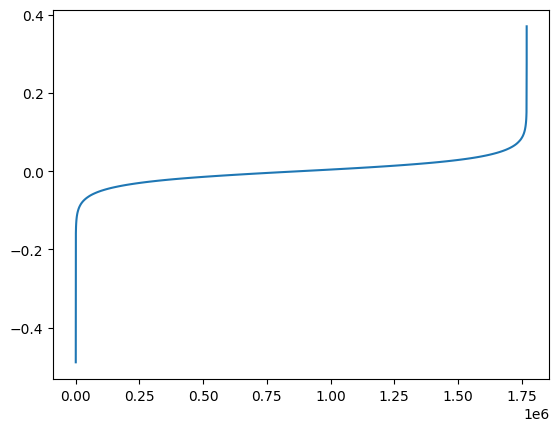

In [90]:
from special_neurons import find_linear_layer_pairs, ordered_magnitude_output
import matplotlib.pyplot as plt

linear_layer_pairs = find_linear_layer_pairs(model_og)
LAYER_PLOT = 0

plt.plot(ordered_magnitude_output(linear_layer_pairs[LAYER_PLOT])[0].flatten().sort()[0].cpu().detach().numpy())

## Look at the most negative wire settings

In [91]:
import transformer_lens

def get_weights_from_transformer_lens(name: str):
  #  TODO: this is a hack with gpt_ne_x
  match = re.match(r"gpt_neox\.layers\.(\d+)\.mlp", name)
  if not match:
    raise ValueError(f"Name {name} does not match the expected pattern")
  print(name)
  layer_number = int(match.group(1))
  hooked_name = f"blocks.{layer_number}.mlp.hook_post"
  print(activations[hooked_name].shape)
  return hooked_name

# Load a model (eg GPT-2 Small)
model = transformer_lens.HookedTransformer.from_pretrained(model_name)
# Run the model and get logits and activations
# logits, activations = model.run_with_cache("""the umpires, the umpires, the umpires, the umpires, the umpires""")
logits, activations = model.run_with_cache("hello world is good and I like rice with a side of sweet")
# logits, activations = model.run_with_cache("Hello world")

# For the first MLP
LAYER_CHECK = 2
trans_lens_name = get_weights_from_transformer_lens(linear_layer_pairs[LAYER_CHECK].prev_layer_name)
weights_layer = linear_layer_pairs[LAYER_CHECK].linear_layer.weight
activations_prev_layer = activations[trans_lens_name]
activations_prev_layer = activations_prev_layer.squeeze(0)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loaded pretrained model EleutherAI/pythia-160m into HookedTransformer
gpt_neox.layers.0.mlp
torch.Size([1, 14, 3072])


In [92]:
tokenizer_vocab_size = len(model.tokenizer)
tokenizer_vocab_size

50277

In [93]:
n_tokens = activations_prev_layer.shape[0]
n_tokens

14

In [94]:
weights_layer.shape, activations_prev_layer.shape

(torch.Size([3072, 768]), torch.Size([14, 3072]))

In [95]:
def plot_distr_outgoing(token: int, is_min=True, sort_out=True):
	most = float('inf') if is_min else float('-inf')
	most_idx= -1
	vs = torch.zeros_like(weights_layer[0])
	for outgoing_wire in range(weights_layer.shape[1]):
		tmp = activations_prev_layer[token] * weights_layer.T[outgoing_wire]
		v = min(tmp) if is_min else max(tmp)
		if (is_min and v < most) or (not is_min and v > most):
			most = v
			most_idx = outgoing_wire
		vs[outgoing_wire] = v
	print("MINS", most_idx, most)
	if not sort_out:
		plt.plot(vs.cpu().detach().numpy())
		return
	if not is_min:
		plt.plot(vs.sort()[0].cpu().detach().numpy())
	else: 
		plt.plot(vs.sort()[0].cpu().detach().numpy()[::-1])

In [96]:
FOR_TOK = 2
# plot_distr_outgoing(FOR_TOK, is_min=True, sort_out=True)
# plot_distr_outgoing(FOR_TOK, is_min=False, sort_out=True)

In [97]:
# FOR_TOK = n_tokens - 1
# plot_distr_outgoing(FOR_TOK, is_min=True, sort_out=False)
# plot_distr_outgoing(FOR_TOK, is_min=False, sort_out=False)

## Pass a Repetition Input through the first layer and do Fourier Transform

In [98]:
# The two below are the same
# activations['blocks.0.hook_resid_post'], activations['blocks.1.hook_resid_pre']


# THIS PLOT WITH THE WRONG ALIGNMENT ACTUALLY SHOWS THE FOURIER FEATURE WEIGHT!
non_rep_str = """hello world is good and I like rice with a side of sweet"""
repetition_str = """the umpires, the umpires, the umpires, the umpires, the umpires"""

(29, 768)

(25, 768)


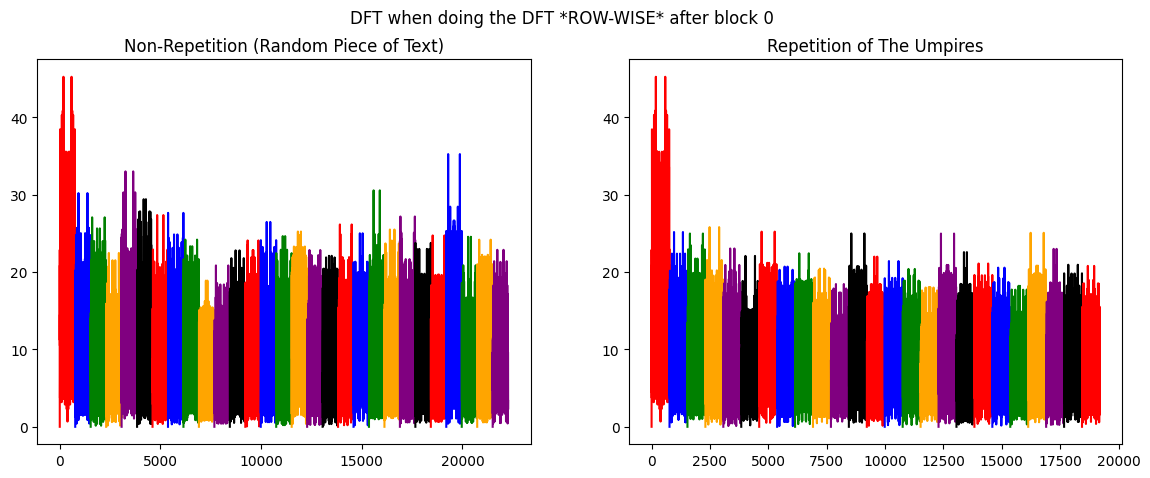

In [133]:
import numpy as np

AFTER_BLOCK = 0

def plot_dft(ax, inp: str, axis=-1, title=None, max_thresh=-1, remove_first=False, after_block=AFTER_BLOCK, plot_feature_distr=False):
	BLOCK_LABEL = f"blocks.{after_block}.hook_resid_post"
	colors = ['red', 'blue', 'green', 'orange', 'purple', 'black']
	_, activations = model.run_with_cache(inp)
	after_block_0 = activations[BLOCK_LABEL][0]
	after_block_0 = after_block_0[1:] if remove_first else after_block_0
	dftmtx = np.fft.fft(after_block_0.cpu().detach().numpy(), axis=axis)
	print(dftmtx.shape)

	# dftmtx_elems_sorted = dftmtx.flatten()[dftmtx.flatten().argsort()]
	# plt.plot(dftmtx_elems_sorted)
	# ax.plot(np.abs(dftmtx.flatten()))
	if ((axis == 1 or axis == -1) and not plot_feature_distr) or (axis == 0 and plot_feature_distr):
		for i in range(0, dftmtx.shape[0] * dftmtx.shape[1], dftmtx.shape[1]):
			end = i + dftmtx.shape[1]
			idx = i // dftmtx.shape[1]
			max_val = abs(dftmtx[idx]).max()
			if max_val > max_thresh:
				# print(f"{idx}: MAX {max_val} ARG {abs(dftmtx[idx]).argmax()}")
				ax.plot(range(i, end), np.abs(dftmtx[idx]), color=colors[(i//dftmtx.shape[1]) % len(colors)])
	elif ((axis == 1 or axis == -1) and plot_feature_distr) or (axis == 0 and not plot_feature_distr):
		for i in range(0, dftmtx.shape[0] * dftmtx.shape[1], dftmtx.shape[0]):
			end = i + dftmtx.shape[0]
			idx = i // dftmtx.shape[0]
			max_val = abs(dftmtx[:, idx]).max()
			if max_val > max_thresh:
				# print(f"{idx}: MAX {max_val} ARG {abs(dftmtx[:, idx]).argmax()}")
				ax.plot(range(i, end), np.abs(dftmtx[:, idx]), color=colors[(i//dftmtx.shape[0]) % len(colors)])
	else:
		raise ValueError(f"Axis {axis} not supported")
	if title:
		ax.set_title(title)
	return dftmtx
# plt.plot(dftmtx[2].flatten())
# _ = plot_dft(non_rep_str)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
_ = plot_dft(ax1, "abcdefksdj kasnaye28oed98wq0 CLDCDHGCOUAVCrfij skdsfdl", title="Non-Repetition (Random Piece of Text)")
print()
_ = plot_dft(ax2, repetition_str, title="Repetition of The Umpires")
fig.suptitle(f"DFT when doing the DFT *ROW-WISE* after block {AFTER_BLOCK}")
plt.savefig(f"figs/dft_row_wise__after_block_{AFTER_BLOCK}.png")
plt.show()

(29, 768)
(20, 768)


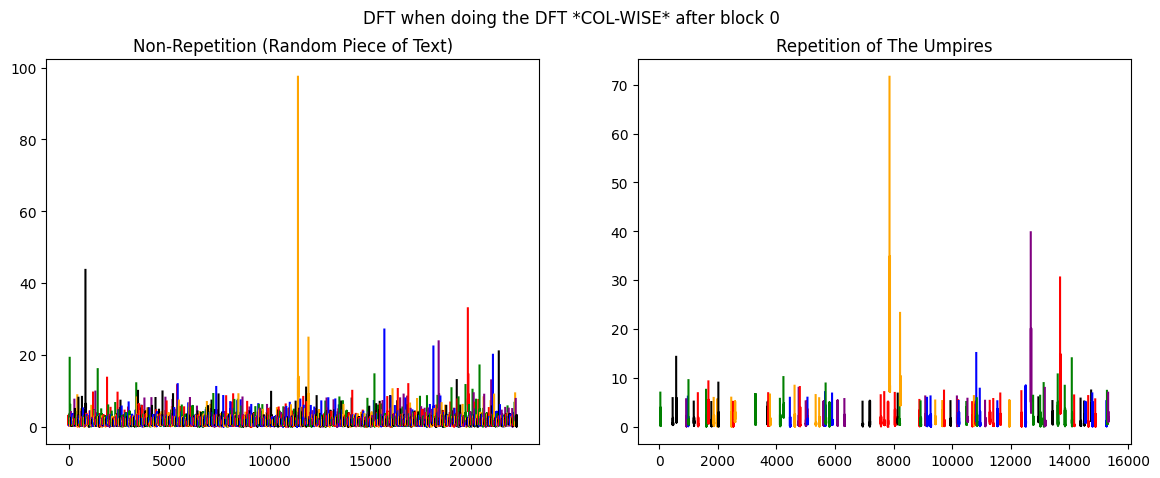

In [134]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
repetition_str_alt = "the umpires, the umpires, the umpires, the umpires"
_ = plot_dft(ax1, "abcdefksdj kasnaye28oed98wq0 CLDCDHGCOUAVCrfij skdsfdl", title="Non-Repetition (Random Piece of Text)", axis=0)
_ = plot_dft(ax2, repetition_str_alt, title="Repetition of The Umpires", axis=0, max_thresh=5)
fig.suptitle(f"DFT when doing the DFT *COL-WISE* after block {AFTER_BLOCK}")
plt.savefig(f"figs/dft_col_wise__after_block_{AFTER_BLOCK}.png")
plt.show()
# print()

In [101]:
spiked_token = model.tokenizer(repetition_str)['input_ids'][5]
model.tokenizer.decode([spiked_token])

' the'

In [102]:
# Its 4 tokens each time...
len('the umpires')

11

(732, 768)
(173, 768)
(502, 768)
(274, 768)


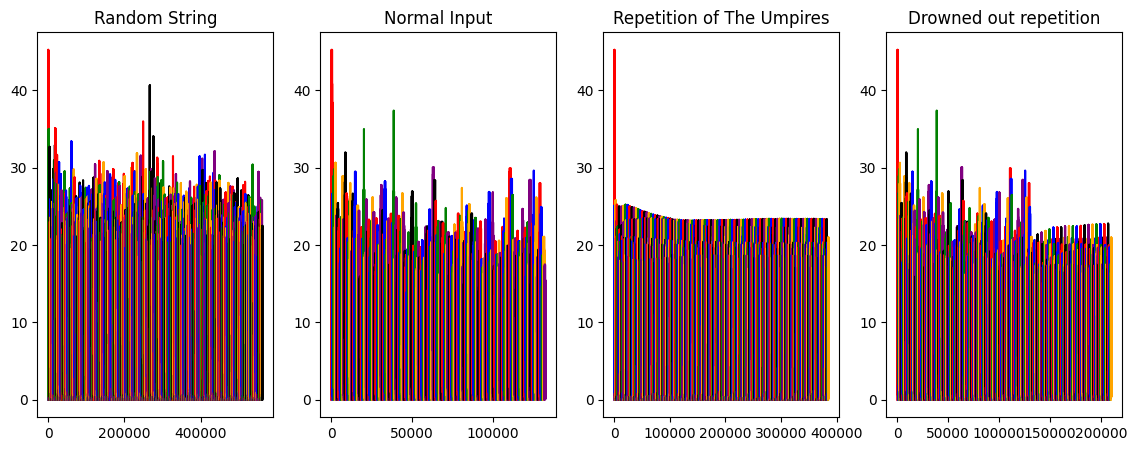

In [137]:
import random
import string


def generate_random_string(length):
    # Generate a random string of the specified length
    return ''.join(random.choice(string.ascii_letters + string.digits) for _ in range(length))


rand_str = generate_random_string(1000)
normal_str = """In NumPy, a column-wise Discrete Fourier Transform (DFT) applies the DFT to each column of a matrix individually, treating each column as a separate signal. A row-wise DFT applies the DFT to each row of the matrix individually, treating each row as a separate signal.

Column-wise DFT (numpy.fft.fft on each column): Applies the Fourier Transform along the columns of the input array. If your array is 2D, this means each column is transformed independently, which is akin to treating each column as a distinct time series or signal.

Row-wise DFT (numpy.fft.fft on each row): Applies the Fourier Transform along the rows. In a 2D context, this means you're transforming each row independently, treating them as separate entities or signals."""
rep_str = "the umpires, " * 100

drowned_out = normal_str + "the umpires, " * 20

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(14, 5))
AXIS = 0
_ = plot_dft(ax1, rand_str, title="Random String",
             axis=AXIS, max_thresh=20, remove_first=False)
_ = plot_dft(ax2, normal_str, title="Normal Input",
             axis=AXIS, max_thresh=10, remove_first=False)
_ = plot_dft(ax3, rep_str, title="Repetition of The Umpires",
             axis=AXIS, max_thresh=10, remove_first=False)
_ = plot_dft(ax4, drowned_out, title="Drowned out repetition",
             axis=AXIS, max_thresh=10, remove_first=False)

(732, 768)
(173, 768)
(501, 768)
(274, 768)


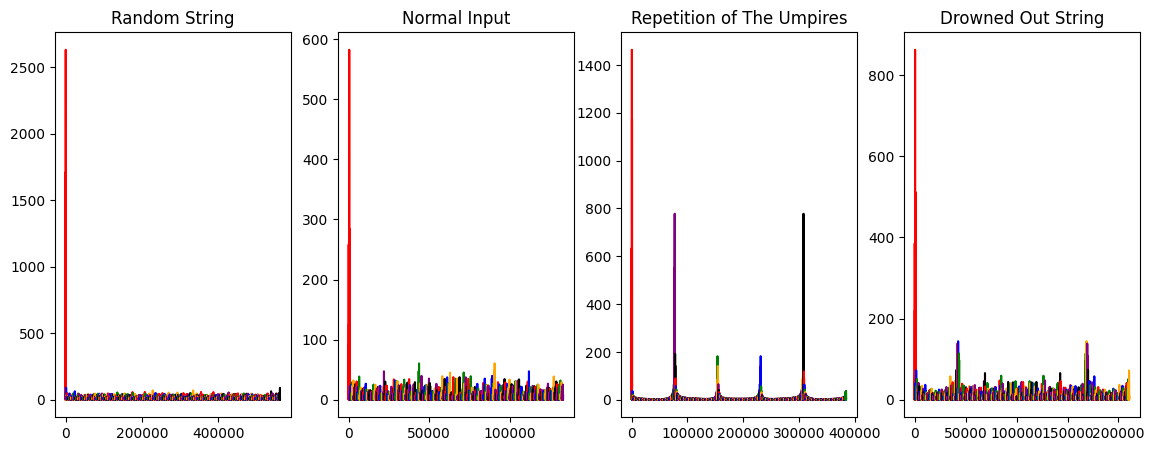

In [142]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(14, 5))
after_block = 0
AXIS = 0
_ = plot_dft(ax1, rand_str, title="Random String", axis=AXIS, max_thresh=0, after_block=after_block, plot_feature_distr=True)
_ = plot_dft(ax2, normal_str, title="Normal Input", axis=AXIS, max_thresh=0, after_block=after_block, plot_feature_distr=True)
_ = plot_dft(ax3, rep_str, title="Repetition of The Umpires", axis=AXIS, max_thresh=0, after_block=after_block, plot_feature_distr=True, remove_first=False)
_ = plot_dft(ax4, drowned_out, title="Drowned Out String", axis=AXIS, max_thresh=0, after_block=after_block, plot_feature_distr=True)

In [104]:
args = np.abs(dftmtx[0].flatten()).argsort()[::-1]
# dftmtx[0][args]
args[0:10]

NameError: name 'dftmtx' is not defined

/home/lev/.local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


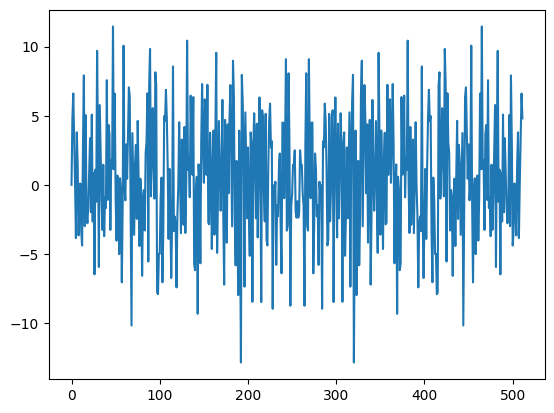

In [ ]:
plt.plot(dftmtx[10])

## What is the distribution of weights on the attention head

In [ ]:
activations.keys()

dict_keys(['hook_embed', 'blocks.0.hook_resid_pre', 'blocks.0.ln1.hook_scale', 'blocks.0.ln1.hook_normalized', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_rot_q', 'blocks.0.attn.hook_rot_k', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.hook_attn_out', 'blocks.0.ln2.hook_scale', 'blocks.0.ln2.hook_normalized', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_pre', 'blocks.1.ln1.hook_scale', 'blocks.1.ln1.hook_normalized', 'blocks.1.attn.hook_q', 'blocks.1.attn.hook_k', 'blocks.1.attn.hook_v', 'blocks.1.attn.hook_rot_q', 'blocks.1.attn.hook_rot_k', 'blocks.1.attn.hook_attn_scores', 'blocks.1.attn.hook_pattern', 'blocks.1.attn.hook_z', 'blocks.1.hook_attn_out', 'blocks.1.ln2.hook_scale', 'blocks.1.ln2.hook_normalized', 'blocks.1.mlp.hook_pre', 'blocks.1.mlp.hook_post', 'blocks.1.hook_mlp_out', 'blocks.1.hook_resid_

In [ ]:
(activations['blocks.1.mlp.hook_post'][0][0].min())

tensor(-0.1700, device='cuda:0')

In [ ]:
prop_off = 1  - (activations['blocks.1.mlp.hook_post'][0][0] > -0.16).nonzero().shape[0] / 2048

print(f"Proportion of negative activations: {prop_off}")

Proportion of negative activations: 0.1669921875


In [ ]:
# activations['blocks.0.attn.hook_attn_scores'].shape
print(activations['blocks.4.attn.hook_pattern'][0][1][0].cpu().detach().numpy() )
print(activations['blocks.4.attn.hook_pattern'][0][1][1].cpu().detach().numpy() )
print(activations['blocks.4.attn.hook_pattern'][0][1][10].cpu().detach().numpy() )
print(activations['blocks.4.attn.hook_pattern'][0][1][-2].cpu().detach().numpy() )
print(activations['blocks.4.attn.hook_pattern'][0][1][-1].cpu().detach().numpy() )
# plt.plot(activations['blocks.0.attn.hook_attn_scores'][0][0][0].cpu().detach().numpy() )
# activations['blocks.0.hook_attn_out']
# activations['blocks.0.attn.hook_z'].shape
# activations['blocks.0.attn.hook_pattern'].shape

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.9988883  0.00111167 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
[4.0015128e-02 3.7221371e-06 7.5730662e-07 2.8542878e-05 3.2149560e-06
 1.1817381e-05 3.5343883e-06 8.4715459e-05 9.5865107e-01 2.4441522e-04
 9.5308898e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00]
[9.0759754e-01 1.6893937e-05 7.5901511e-08 8.6130276e-05 7.6009703e-05
 9.7870125e-06 1.3656470e-04 1.5854894e-05 8.8557534e-02 7.0445437e-04
 2.5692487e-03 1.7881105e-04 5.1080358e-05 0.0000000e+00]
[5.67209184e-01 1.28458612e-06 1.30953115e-08 1.21402982e-05
 1.28564920e-07 5.49347806e-06 2.13037060e-06 2.72785492e-05
 4.28989023e-01 3.13408294e-04 2.50641443e-03 9.66020343e-06
 1.22732468e-04 8.01098126e-04]


ValueError: x and y can be no greater than 2D, but have shapes (8,) and (8, 14, 14)

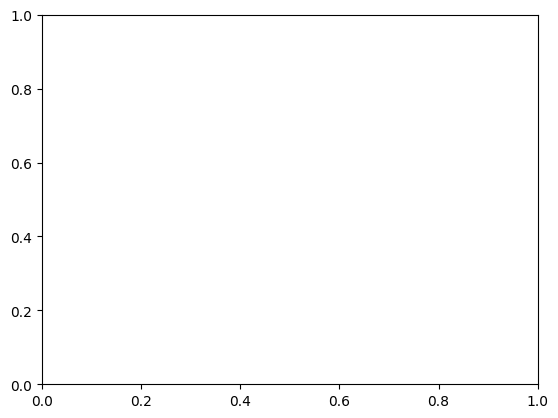

In [ ]:
plt.plot(activations['blocks.0.attn.hook_pattern'][0].cpu().detach().numpy())
# activations.keys()

## Setup Some Basic SDP

In [ ]:
!pip install cvxpy -q

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
# Check if parrallel residuals are used as per line 709 of tranformers/models/gpt_neox/modeling_gpt_neox.py
assert model_og.gpt_neox.layers[0].use_parallel_residual == True

In [ ]:
import cvxpy as cp
import numpy as np

TARGET_TOKEN = 0
TARGET_NEURON = 0
TARGET_LAYER = 0
assert TARGET_LAYER == 0, "We only support the first layer for now"
# seed = 69_420
# np.random.seed(seed)

# We have a dimension `tokenizer_vocab_size`-vector for each token
n_dim = tokenizer_vocab_size * n_tokens
X = cp.Variable((n_dim, n_dim), PSD=True)

# Ensure every element is 0 <= x
constraints = [X >= 0]

# Add each unary-ish constraint
for tok in range(n_tokens):
	for i in range(tokenizer_vocab_size):
		for j in range(tokenizer_vocab_size):
			idx = tok * tokenizer_vocab_size + i
			idy = tok * tokenizer_vocab_size + j
			if i != j:
				# Ensure that cross-terms are 0
				constraints.append(X[idx, idy] == 0)
	start_idx = tok * tokenizer_vocab_size
	end_idx = (tok + 1) * tokenizer_vocab_size
	sub_matrix = X[start_idx:end_idx, start_idx:end_idx]
	# Ensure that the sum of squares is 1
	constraints.append(cp.trace(sub_matrix) == 1)

def module_to_np(module: torch.Tensor):
	return module.cpu().detach().numpy()

def build_obj():
	# We want to recreate what the neural network is doing
	embed = np.kron(np.eye(n_tokens), module_to_np(model.embed.W_E))
	print(embed.shape)
	model_og
	# TODO: WHERE IS POSITIONAL EMBEDDING?
	post_embed = embed @ X
	# TODO: then nn.dropout for embeding

	# TODO: what about residuals???

	# Then, line 671 get GPTNeoXLayer 


	
			



q = cp.Parameter(n_dim, nonneg=True)


KeyboardInterrupt: 

## Look at most negative individual neuron

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM

# Initialize the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_name)  # Replace MODEL_NAME with the actual model name

# Encode the input text
input_text = "The boy with the SFdfdrgfeDSSD"  # Replace YOUR_INPUT_TEXT with your actual input text
input_ids = tokenizer.encode(input_text, return_tensors='pt').to(device)

# Forward pass to get output logits
outputs = model(input_ids, output_hidden_states=True)
hidden_states = outputs.hidden_states  # Hidden states of all layers

# Access the specific neuron's value
# Replace LAYER_INDEX, BATCH_INDEX, TOKEN_INDEX, NEURON_INDEX with actual indices
# neuron_value = hidden_states[LAYER_INDEX][BATCH_INDEX, TOKEN_INDEX, NEURON_INDEX].item()

print(hidden_states[2].shape)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


TypeError: HookedTransformer.forward() got an unexpected keyword argument 'output_hidden_states'

In [ ]:
import transformer_lens

# Load a model (eg GPT-2 Small)
model = transformer_lens.HookedTransformer.from_pretrained(model_name)
# Run the model and get logits and activations
logits, activations = model.run_with_cache("Hello World")

ModuleNotFoundError: No module named 'transformer_lens'

In [ ]:
activations

ActivationCache with keys ['hook_embed', 'blocks.0.hook_resid_pre', 'blocks.0.ln1.hook_scale', 'blocks.0.ln1.hook_normalized', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_rot_q', 'blocks.0.attn.hook_rot_k', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.hook_attn_out', 'blocks.0.ln2.hook_scale', 'blocks.0.ln2.hook_normalized', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_pre', 'blocks.1.ln1.hook_scale', 'blocks.1.ln1.hook_normalized', 'blocks.1.attn.hook_q', 'blocks.1.attn.hook_k', 'blocks.1.attn.hook_v', 'blocks.1.attn.hook_rot_q', 'blocks.1.attn.hook_rot_k', 'blocks.1.attn.hook_attn_scores', 'blocks.1.attn.hook_pattern', 'blocks.1.attn.hook_z', 'blocks.1.hook_attn_out', 'blocks.1.ln2.hook_scale', 'blocks.1.ln2.hook_normalized', 'blocks.1.mlp.hook_pre', 'blocks.1.mlp.hook_post', 'blocks.1.hook_mlp_out', 'bloc

In [ ]:
N_MAX_LOOK = 100

# Okie, this is what we want!!


def find_logits_on_mlps():
    for layer_pair in most_neg:
        name = layer_pair.prev_layer_name
        match = re.match(r"gpt_neox\.layers\.(\d+)\.mlp", name)
        if match:
            print(name)
            layer_number = int(match.group(1))
            hooked_name = f"blocks.{layer_number}.mlp.hook_post"
            print(activations[hooked_name].shape)
            # Find the most positive activations
            # TODO: this is weird... it has to be **per token**
            most_neg_out = layer_pair.most_negatives.tolist()
            n_tokens = activations[hooked_name].shape[1]
            print("N Tokens", n_tokens)
            for tok_idx in range(n_tokens):
                maxed = activations[hooked_name][0, tok_idx].argsort(descending=True)[
                    :N_MAX_LOOK]
                for m in maxed:
                    for j in range(len(most_neg_out)):
                        if m == most_neg_out[j]:
                            print(f"Found a match: {m}")
                            # TODO: print token
                            print(
                                f"Activations: {activations[hooked_name][:, tok_idx, m]} on token {tok_idx} with negative value {layer_pair.most_negatives_vals[j]}")
                            effective_change = layer_pair.most_negatives_vals[j] * activations[hooked_name][:, tok_idx, m]
                            print("Effective change", effective_change.item())
                            print()


find_logits_on_mlps()

gpt_neox.layers.0.mlp
torch.Size([1, 3, 2048])
N Tokens 3
Found a match: 227
Activations: tensor([0.4309], device='cuda:0') on token 1 with negative value -13.506959915161133
Effective change tensor([-5.8199], device='cuda:0', grad_fn=<MulBackward0>)

Found a match: 249
Activations: tensor([0.3862], device='cuda:0') on token 1 with negative value -74.46073150634766
Effective change tensor([-28.7561], device='cuda:0', grad_fn=<MulBackward0>)

gpt_neox.layers.1.mlp
torch.Size([1, 3, 2048])
N Tokens 3
Found a match: 47
Activations: tensor([1.0227], device='cuda:0') on token 1 with negative value -17.482093811035156
Effective change tensor([-17.8796], device='cuda:0', grad_fn=<MulBackward0>)

Found a match: 157
Activations: tensor([0.5185], device='cuda:0') on token 2 with negative value -21.773366928100586
Effective change tensor([-11.2893], device='cuda:0', grad_fn=<MulBackward0>)

gpt_neox.layers.2.mlp
torch.Size([1, 3, 2048])
N Tokens 3
Found a match: 111
Activations: tensor([0.8778], 